# Monte Carlo method for option pricing

## Prepare

### Imports

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

import math as m
from time import time
from scipy import stats

### parameters

In [2]:
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2

### TV calculation

In [3]:
def N(x):
    return stats.norm.cdf(x, 0.0, 1.0)

def NPrime(x):
    return stats.norm.pdf(x, 0.0, 1.0)

def bsm_d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_d2(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_pv(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    d2 = bsm_d2(S, K, T, r, q, sigma)
    if isCall:
        return S * N(d1) * m.exp(-q * T) - K * m.exp(-r * T) * N(d2)
    else:
        return K * N(-d2) * m.exp(-r * T)  - S * m.exp(-q * T) * N(-d1)

def bsm_delta(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    if isCall:
        return N(d1) * m.exp(-q * T)
    else:
        return -N(-d1) * m.exp(-q * T)

#S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0;
#sigma = 0.2

ref_pv = bsm_pv(True, S=S0, K=K, T=T, r=r, q=q, sigma=sigma)
ref_delta = bsm_delta(True, S=S0, K=K, T=T, r=r, q=q, sigma=sigma)
print( "ref_pv: %.6f, ref_delta: %.6f " % (ref_pv, ref_delta) )


ref_pv: 5.988244, ref_delta: 0.518694 


## Execersices

$ C_0 = E\left[ e^{-rT} max(0, S_T - K) \right] $

$S(t) = S(t-\Delta t) \exp(r t - \frac{1}{2} \sigma^2 t + \sigma W_t )$

### Euro option with paths

In [4]:
def mc_call_pv_with_paths0(S0, K, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)

    # PV is extected discounted payoff
    C = np.sum(m.exp(-r * T) * np.maximum(S[-1] - K, 0)) / I
    return C, S

def standard_normal(I):
    z = np.random.standard_normal(I)
    mean = np.mean(z)
    std = np.std(z)
    return (z - mean)/std    

def mc_call_pv_with_paths(S0, K, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)

    # PV is extected discounted payoff
    C = np.sum(m.exp(-r * T) * np.maximum(S[-1] - K, 0)) / I
    return C, S


# Parameters
M = 360 # number of steps in time
I = 50000 # number of paths to generate

np.random.seed(12345)
t0 = time()
C, SPaths = mc_call_pv_with_paths0(S0, K, T, r, sigma, M, I)
calcTime = time() - t0

print( "PV: %.5f, abs diff: %.5f, rel diff:  %.5f" % (C, ref_pv - C, (ref_pv - C)/C) )
print( "Calculation time   %.5f" % calcTime )

np.random.seed(12345)
t0 = time()
C, SPaths = mc_call_pv_with_paths(S0, K, T, r, sigma, M, I)
calcTime = time() - t0

print( "PV: %.5f, abs diff: %.5f, rel diff:  %.5f" % (C, ref_pv - C, (ref_pv - C)/C) )
print( "Calculation time   %.5f" % calcTime )

PV: 5.95967, abs diff: 0.02858, rel diff:  0.00480
Calculation time   1.54988
PV: 5.98041, abs diff: 0.00784, rel diff:  0.00131
Calculation time   1.70743


Text(0, 0.5, 'Spot')

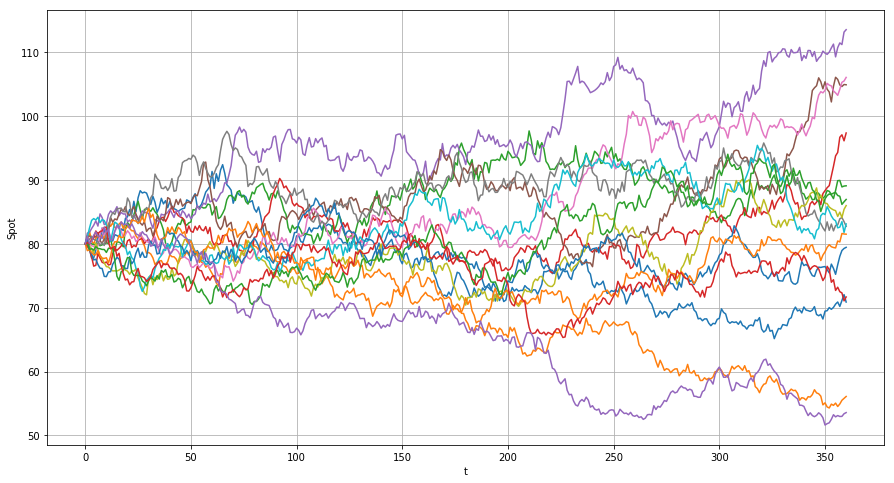

In [5]:
plt.figure(figsize=(15,8))
plt.plot(SPaths[:, :15])
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Spot')

Text(0, 0.5, 'Spot')

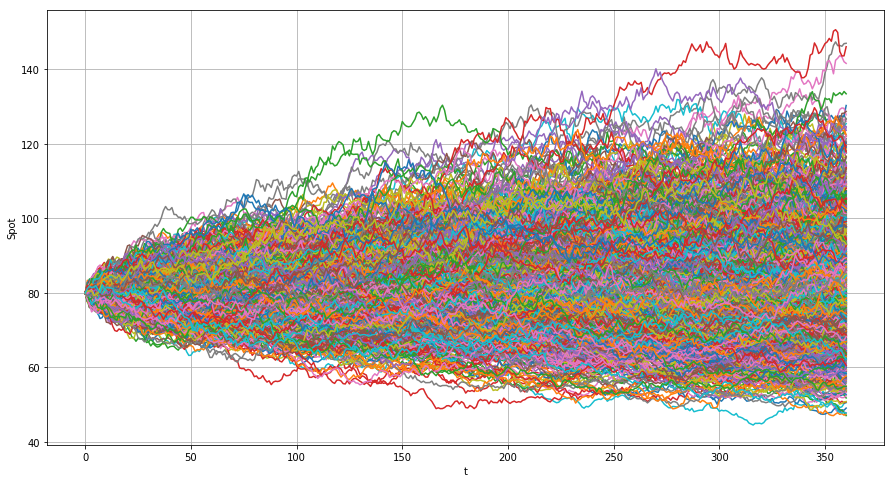

In [6]:
plt.figure(figsize=(15,8))
plt.plot(SPaths[:, :1000])
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Spot')

### Euro option without paths

In [7]:
def mc_call_pv_no_paths(S0, K, T, r, sigma, I):
    # Simulating I values
    z = standard_normal(I)
    S = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * m.sqrt(T) * z)

    # payoff
    P = np.maximum(S - K, 0)
    # PV as expected discounted payoff
    C = np.sum( m.exp(-r * T) * P ) / I
    return C, S

np.random.seed(12345)
t0 = time()
C, S = mc_call_pv_no_paths(S0, K, T, r, sigma, I)
calcTime = time() - t0

print( "PV: %.5f, abs diff: %.5f, rel diff:  %.5f" % (C, ref_pv - C, (ref_pv - C)/C) )
print( "Calculation time   %.5f" % calcTime )

PV: 5.98935, abs diff: -0.00110, rel diff:  -0.00018
Calculation time   0.00997


Text(0.5, 0, 'Spot')

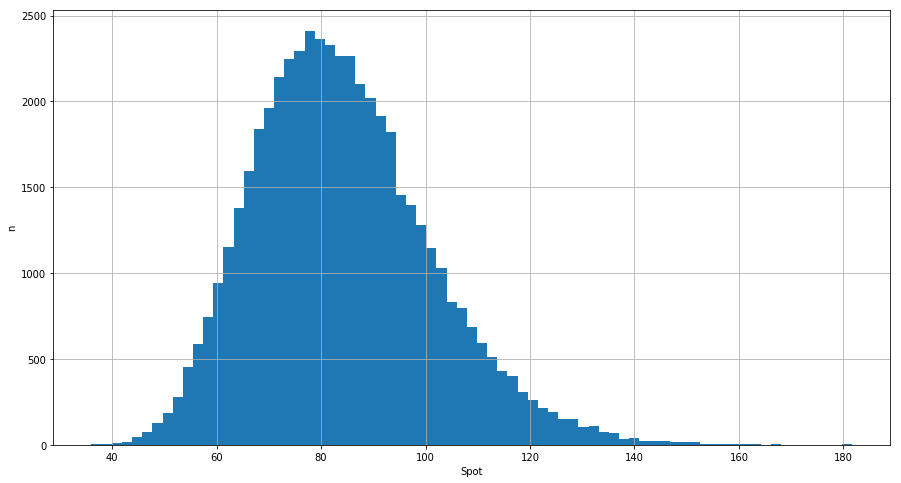

In [8]:
plt.figure(figsize=(15,8))
plt.hist(S, 75)

plt.grid(True)
plt.ylabel('n')
plt.xlabel('Spot')

In [9]:
print( "Expected mean: %.5f, mean: %.5f" % (S0 * m.exp(r*T), np.mean(S)) )
print( "Expected std: %.5f, std:  %.5f" % ( S0* m.exp(r*T ) * m.sqrt(m.exp( sigma * sigma *T ) - 1) , np.std(S)) )
# Std formular: https://en.wikipedia.org/wiki/Geometric_Brownian_motion#Properties

Expected mean: 84.10169, mean: 84.09980
Expected std: 16.98995, std:  16.95558


In [10]:
z = standard_normal(I)
z = z * np.std(S)
z = z + np.mean(S)

Text(0, 0.5, 'Spot')

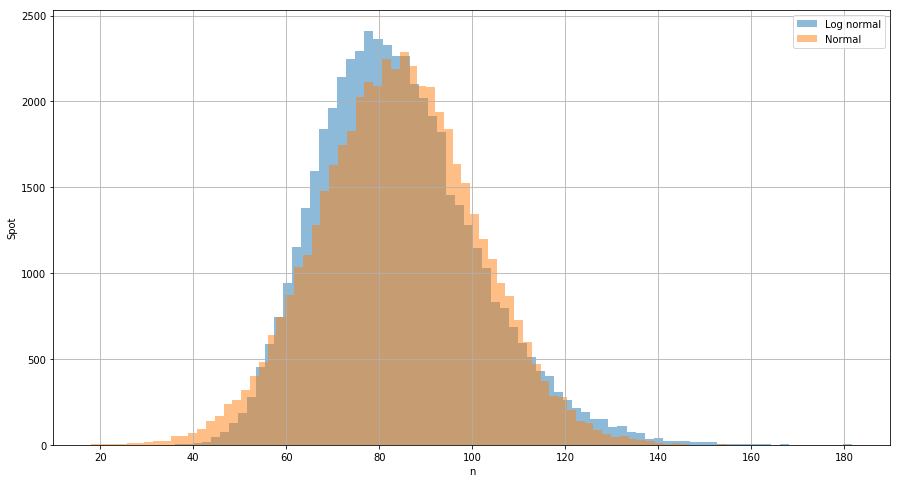

In [11]:
plt.figure(figsize=(15,8))
plt.hist(S, 75, alpha=0.5, label='Log normal')
plt.hist(z, 75, alpha=0.5, label='Normal')

plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('n')
plt.ylabel('Spot')

### Digital (Binary) option

In [12]:
def mc_bin_call_pv_no_paths(S0, K, T, r, sigma, I):
    # Simulating I values
    z = standard_normal(I)
    
    S = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * m.sqrt(T) * z)

    # payoff
    P = S
    P[ P < K ] = 0
    P[ P >= K ] =1
    # PV as expected discounted payoff
    C = np.sum( m.exp(-r * T) * P ) / I
    return C, S


np.random.seed(12345)
t0 = time()
C, S = mc_bin_call_pv_no_paths(S0, K, T, r, sigma, I)
calcTime = time() - t0

print( "PV: %.7f " % (C) )
print( "Calculation time   %.5f" % calcTime )

PV: 0.4195302 
Calculation time   0.00798


Text(0, 0.5, 'n')

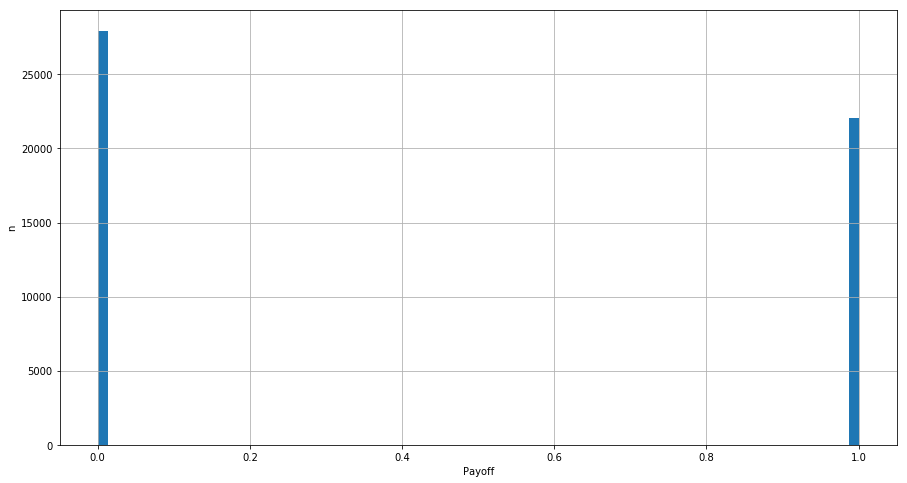

In [14]:
plt.figure(figsize=(15,8))
plt.hist(S, 75)
plt.grid(True)
plt.xlabel('Payoff')
plt.ylabel('n')

### Barrier option : KO

In [15]:
def mc_bar_call_pv_with_paths(S0, K, B, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = standard_normal(I)
        
        S_next = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)
        # TODO : need to check if barrier level is breached
        S[t] = S_next

    # PV is extected discounted payoff
    C = 0 # TODO : must be some function of S_T
    return C, S


# Parameters
B = 110

np.random.seed(12345)
t0 = time()
C, SPaths = mc_bar_call_pv_with_paths(S0, K, B, T, r, sigma, M, I)
calcTime = time() - t0

print( "PV: %.5f" % C )
print( "Calculation time   %.5f" % calcTime )

PV: 0.00000
Calculation time   1.17090


Text(0, 0.5, 'Spot')

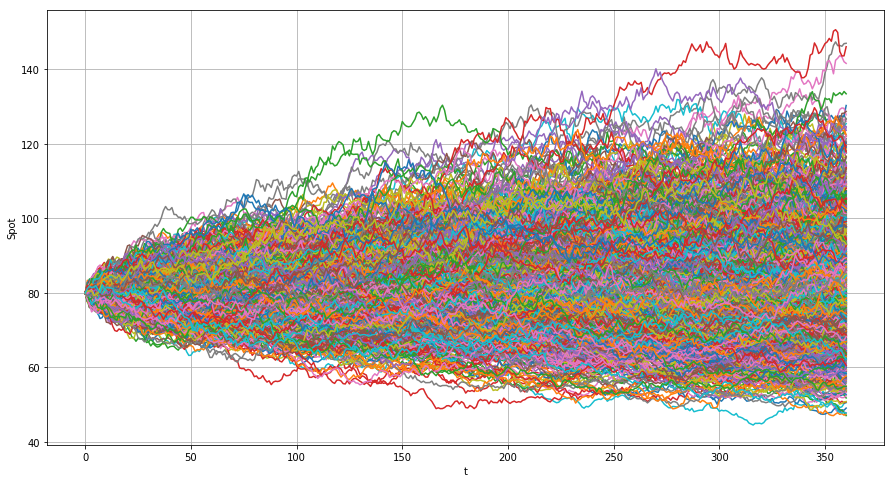

In [16]:
plt.figure(figsize=(15,8))
plt.plot(SPaths[:, :1000])
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Spot')

## Delta

.  
.  

$\frac{ \partial C  }{ \partial S} \approx \frac{ \Delta C }{ \Delta S} = \frac{ C_{i+1} - C_i }{ \Delta S }$

In [102]:
dS = 1

mc_call_pv = mc_call_pv_no_paths

np.random.seed(12345)
t0 = time()
C0, _ = mc_call_pv(S0, K, T, r, sigma, I)
C1, _ = mc_call_pv(S0+dS, K, T, r, sigma, I)
delta = (C1 - C0) / dS
calcTime = time() - t0

print( "Delta: %.5f, abs diff: %.5f, rel diff:  %.5f" % (delta, ref_delta - delta, (ref_delta - delta)/delta) )
print( "Calculation time   %.5f" % calcTime )

Delta: 0.52923, abs diff: -0.01054, rel diff:  -0.01991
Calculation time   0.02232


$\frac{ \partial C  }{ \partial S} \approx \frac{ C_{i+1} - C_{i-1} }{ 2 \Delta S }$

In [103]:
np.random.seed(12345)
t0 = time()
C_1, _ = mc_call_pv(S0-dS, K, T, r, sigma, I)
C1, _ = mc_call_pv(S0+dS, K, T, r, sigma, I)
delta = (C1 - C_1) / (2. * dS)
calcTime = time() - t0

print( "Delta: %.5f, abs diff: %.5f, rel diff:  %.5f" % (delta, ref_delta - delta, (ref_delta - delta)/delta) )
print( "Calculation time   %.5f" % calcTime )

Delta: 0.51896, abs diff: -0.00027, rel diff:  -0.00052
Calculation time   0.01194


## QuantLib

In [21]:
print( "ref_pv: %.6f, ref_delta: %.6f " % (ref_pv, ref_delta) )

ref_pv: 5.988244, ref_delta: 0.518694 


In [22]:
from QuantLib import *

In [23]:
# global data
todaysDate = Date(17,March,2017)
Settings.instance().evaluationDate = todaysDate
settlementDate = todaysDate
dayCounter = SimpleDayCounter() # Actual365Fixed()
riskFreeRate = FlatForward(settlementDate, r, dayCounter)

# option parameters
exercise = EuropeanExercise(Date(17,March,2018))
payoff = PlainVanillaPayoff(Option.Call, K)

# market data
underlying = SimpleQuote( S0 )
volatility = BlackConstantVol(todaysDate, TARGET(), sigma, dayCounter)
dividendYield = FlatForward(settlementDate, 0, dayCounter)


#
process = BlackScholesMertonProcess(QuoteHandle(underlying),
                                    YieldTermStructureHandle(dividendYield),
                                    YieldTermStructureHandle(riskFreeRate),
                                    BlackVolTermStructureHandle(volatility))

option = VanillaOption(payoff, exercise)

# method: analytic
option.setPricingEngine(AnalyticEuropeanEngine(process))

print( "QuantLib ref_pv: %.6f, ref_delta: %.6f " % (option.NPV(), option.delta() ) )

QuantLib ref_pv: 5.988244, ref_delta: 0.518694 


In [24]:
# method: Monte Carlo
option.setPricingEngine(MCEuropeanEngine(process,
                                         'pseudorandom',
                                         timeSteps = 1,
                                         requiredTolerance = 0.02,
                                         seed = 42))
print( "QuantLib MC (crude) pv: %.6f, errorEstimate: %.6f " % (option.NPV(), option.errorEstimate() ) )
#report('MC (crude)', option.NPV(), option.errorEstimate())

option.setPricingEngine(MCEuropeanEngine(process,
                                         'lowdiscrepancy',
                                         timeSteps = 1,
                                         requiredSamples = 32768))
#report('MC (Sobol)', option.NPV())
print( "QuantLib MC (Sobol) pv: %.6f " % option.NPV() )

QuantLib MC (crude) pv: 5.971449, errorEstimate: 0.019971 
QuantLib MC (Sobol) pv: 5.986579 
